In [1]:
from foundry.util.runtime import setup
setup()

import foundry.core.tree as tree
import foundry.numpy as jnp
import foundry.random
import foundry.train

from foundry import core as F
from foundry.core.typing import Array
from foundry.data import Data, PyTreeData
from foundry.diffusion import DDPMSchedule
from functools import partial

from foundry.models.embed import SinusoidalPosEmbed
from foundry.models import activation as activations

from typing import Any, Sequence

import flax.linen as nn
import optax

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# raw_data = (jnp.array([-1., 1.]), jnp.array([-1., 1.]))
# raw_data : tuple[Array, Array] = tree.map(lambda x: jnp.repeat(x[None, :], 128, axis=0).reshape(-1), raw_data)


def sample_left(rng_key):
    mode_rng, y_rng = foundry.random.split(rng_key)
    mode = foundry.random.choice(mode_rng, jnp.array([-.5, .5]))
    s = (x + 1)/2.
    y = ((1-s)*mode + x) + 0.05*foundry.random.normal(y_rng)
    return y

N_train = 1024
raw_data_left = F.vmap(sample_y, in_axes=(0, None))(foundry.random.split(foundry.random.key(42), N_train), jnp.array(0.))
raw_data_right = F.vmap(sample_y, in_axes=(0, None))(foundry.random.split(foundry.random.key(42), N_train), jnp.array(0.))
data = PyTreeData(raw_data)

In [3]:
class DiffusionMLP(nn.Module):
    features: Sequence[int]
    activation: str = "relu"
    time_embed_dim: int = 8

    @nn.compact
    def __call__(self, cond, value,
                    # either timestep or time_embed must be passed
                    timestep=None, train=False):
        activation = getattr(activations, self.activation)
        # works even if we have multiple timesteps
        timestep_flat = tree.ravel_pytree(timestep)[0] - 1
        time_embed = F.vmap(
            lambda x: SinusoidalPosEmbed(self.time_embed_dim)(x)
        )(timestep_flat).reshape(-1)
        time_embed = nn.Sequential([
            nn.Dense(self.time_embed_dim),
            activation,
            nn.Dense(self.time_embed_dim),
        ])(time_embed)
        cond_flat = tree.ravel_pytree(cond)[0]
        cond_embed = nn.Sequential([
            nn.Dense(self.time_embed_dim),
            activation,
            nn.Dense(self.time_embed_dim),
        ])(cond_flat)

        # concatenated embedding
        value_flat, value_uf = tree.ravel_pytree(value)
        value = jnp.concatenate((value_flat,cond_flat), axis=-1)
        embed = time_embed # jnp.concatenate((time_embed,cond_embed), axis=-1)
        for feat in self.features:
            shift, scale = jnp.split(nn.Dense(2*feat)(embed), 2, -1)
            value = activation(nn.Dense(feat)(value))
            value = value * (1 + scale) + shift
        value = nn.Dense(value_flat.shape[-1])(value)
        # x = jax.nn.tanh(x)
        value = value_uf(value)
        return value

model = DiffusionMLP(features=(8, 8))

In [4]:
schedule = DDPMSchedule.make_squaredcos_cap_v2(
    16, 
    prediction_type="epsilon",
    clip_sample_range=2.,
)

def train(data, val_data):
    def loss(vars, rng_key, sample):
        x, y = sample
        denoiser = lambda rng_key, noised_y, t: model.apply(vars, x, noised_y, t)
        loss = schedule.loss(rng_key, denoiser, y)
        return foundry.train.LossOutput(
            loss=loss,
            metrics={"loss": loss}
        )
    batch_loss = foundry.train.batch_loss(loss)

    vars = model.init(foundry.random.key(42), 
        jnp.zeros(()), jnp.zeros(()),  0
    )
    iterations = 50_000
    optimizer = optax.adamw(
        optax.cosine_decay_schedule(5e-3, iterations),
        weight_decay=0.0001
    )
    ema = optax.ema(0.9)
    opt_state = optimizer.init(vars["params"])
    ema_state = ema.init(vars)
    ema_update = F.jit(ema.update)

    def linear_loss(vars, rng_key, sample):
        x, y = sample
        linear_denoiser = lambda rng_key, y, t: model.apply(vars, 1., y, t)*(x+1)/2 + model.apply(vars, -1., y, t)*(1 - x)/2
        denoiser = lambda rng_key, noised_y, t: model.apply(vars, x, noised_y, t)
        t = foundry.random.randint(rng_key, (), minval=1, maxval=schedule.num_steps + 1)
        noised, _, _ = schedule.add_noise(rng_key, y, t)
        loss = jnp.mean(jnp.square(linear_denoiser(None, noised, t) - denoiser(None, noised, t)))
        return foundry.train.LossOutput(
            loss=loss,
            metrics={"loss": loss}
        )
    batch_linear_loss = foundry.train.batch_loss(linear_loss)

    @F.jit
    def nn_sample(vars, x, rng_key):
        denoiser = lambda x, rng_key, y, t: model.apply(vars, x, y, t)
        sample = schedule.sample(rng_key, partial(denoiser, x), jnp.zeros(()))
        return x, sample

    history = []
    stream = data.stream().shuffle(foundry.random.key(42)).batch(128)
    with foundry.train.loop(stream, iterations=iterations, progress=False,
            rng_key=foundry.random.key(40)) as loop:
        for epoch in loop.epochs():
            for step in epoch.steps():
                opt_state, vars, metrics = foundry.train.step(batch_loss,
                    optimizer, opt_state, vars, step.rng_key,
                    step.batch
                )
                _, ema_state = ema_update(vars, ema_state)
                if (step.iteration + 1) % 100 == 0 or step.iteration == 0:
                    test_vars = ema_state.ema
                    if (step.iteration + 1) % 2000 == 0 or step.iteration == 0:
                        print(f"Iteration {step.iteration + 1}: {metrics['loss'].item()}")
                    # val_metrics = foundry.train.eval(batch_loss, test_vars, step.rng_key, val_raw_data)
                    # train_samples = F.vmap(nn_sample, in_axes=(None, 0,0))(test_vars, raw_data[0], foundry.random.split(step.rng_key, N_train))
                    # val_samples = F.vmap(nn_sample, in_axes=(None, 0,0))(test_vars, val_raw_data[0], foundry.random.split(step.rng_key, N_val))
                    # val_linear_metrics = foundry.train.eval(batch_linear_loss, test_vars, step.rng_key, val_samples)
                    # train_sq_error = jnp.mean(jnp.square(train_samples[1] - train_samples[0])).item()
                    # val_sq_error = jnp.mean(jnp.square(val_samples[1] - val_samples[0])).item()
                    # history.append({"step": step.iteration, "loss": metrics["loss"].item(), "val_loss": val_metrics['loss'].item(),
                    #                 "linear_val_loss": val_linear_metrics["loss"].item(),
                    #                 "sq_error": train_sq_error, "val_sq_error": val_sq_error})
                    # if (step.iteration + 1) % 1000 == 0 or step.iteration == 0:
                    #     print(f"Iteration {step.iteration + 1}: {metrics['loss'].item()}, linear_error: {val_linear_metrics['loss']}"
                    #         + f" val {val_metrics['loss'].item()} sq_error: {train_sq_error} val_sq_erorr: {val_sq_error}")
    vars = ema_state.ema
    denoiser = lambda x, rng_key, y, t: model.apply(vars, x, y, t)
    return vars, history


In [5]:
# "pretrain" without test data
pretrain_vars, _ = train(data, None)

Iteration 1: 1.21567964553833
Iteration 2000: 0.255729615688324
Iteration 4000: 0.10679759085178375
Iteration 6000: 0.16678957641124725
Iteration 8000: 0.30027756094932556
Iteration 10000: 0.22195959091186523
Iteration 12000: 0.10711687803268433
Iteration 14000: 0.15269771218299866
Iteration 16000: 0.21726185083389282
Iteration 18000: 0.14689761400222778
Iteration 20000: 0.1682763397693634
Iteration 22000: 0.12802302837371826
Iteration 24000: 0.26948976516723633
Iteration 26000: 0.12886656820774078
Iteration 28000: 0.11035177856683731
Iteration 30000: 0.1799449473619461
Iteration 32000: 0.13014809787273407
Iteration 34000: 0.10918150097131729
Iteration 36000: 0.16272826492786407
Iteration 38000: 0.29961904883384705
Iteration 40000: 0.14616893231868744
Iteration 42000: 0.15262505412101746
Iteration 44000: 0.18376758694648743
Iteration 46000: 0.16651862859725952
Iteration 48000: 0.13904410600662231
Iteration 50000: 0.14895950257778168


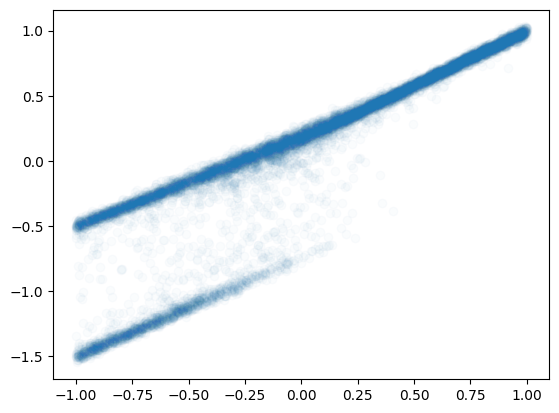

: 

In [54]:
@F.jit
def pretrain_sample(rng_key):
    x_rng, y_rng = foundry.random.split(rng_key)
    x = foundry.random.uniform(x_rng, (), jnp.float32, minval=-1., maxval=1.)
    denoiser = lambda x, rng_key, y, t: model.apply(pretrain_vars, x, y, t)
    sample = schedule.sample(y_rng, partial(denoiser, x), jnp.zeros(()))
    return x, sample

# use the "pretrained" model to generate the validation
# data
rng_keys = foundry.random.split(foundry.random.key(42), 10*1024)
val_raw_data = F.vmap(pretrain_sample)(rng_keys)
val_data = PyTreeData(val_raw_data)
plt.scatter(val_raw_data[0], val_raw_data[1], alpha=0.02)
plt.savefig("gen_interp_nn.svg", transparent=True)

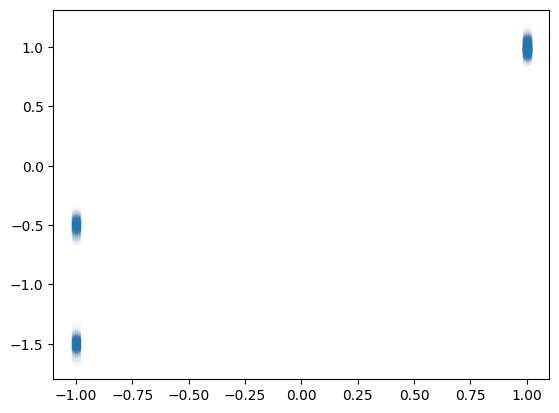

In [53]:
plt.scatter(raw_data[0], raw_data[1], alpha=0.01)
plt.savefig("gen_interp.svg", transparent=True)

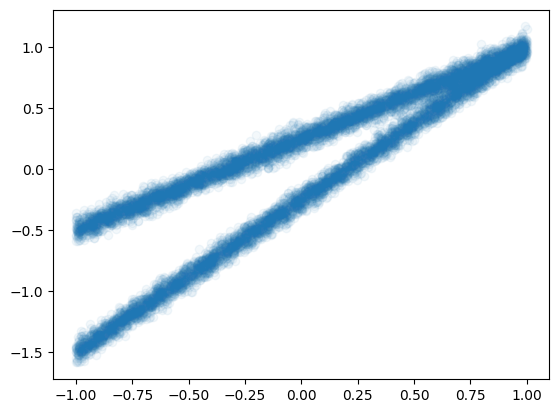

In [51]:
def sample_y(rng_key, x):
    mode_rng, y_rng = foundry.random.split(rng_key)
    mode = foundry.random.choice(mode_rng, jnp.array([-.5, .5]))
    s = (x + 1)/2.
    y = ((1-s)*mode + x) + 0.05*foundry.random.normal(y_rng)
    return y

def sample_interp(rng_key):
    x_rng, y_rng = foundry.random.split(rng_key)
    x = foundry.random.uniform(x_rng, minval=-1., maxval=1.)
    y = sample_y(y_rng, x)
    return (x, y)

N_train = 10*1024
raw_interp_data = F.vmap(sample_interp)(foundry.random.split(foundry.random.key(42), N_train))
plt.scatter(raw_interp_data[0], raw_interp_data[1], alpha=0.05)
plt.savefig("gen_interp_linear.svg", transparent=True)


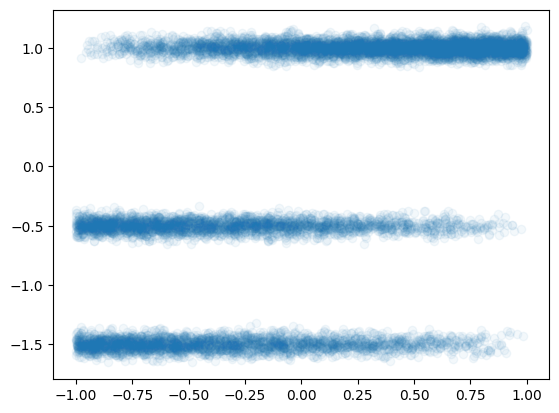

In [52]:
import jax
def sample_y(rng_key, x):
    mode_rng, y_rng = foundry.random.split(rng_key)
    p = (1 - x)/2
    mode = foundry.random.choice(mode_rng, jnp.array([-1.5, -.5, 1.]), p=jnp.array([p/2, p/2, 1-p]))
    y = mode + 0.05*foundry.random.normal(y_rng)
    return y

def sample_interp(rng_key):
    x_rng, y_rng = foundry.random.split(rng_key)
    x = foundry.random.uniform(x_rng, minval=-1., maxval=1.)
    y = sample_y(y_rng, x)
    return (x, y)

N_train = 10*1024
raw_interp_data = F.vmap(sample_interp)(foundry.random.split(foundry.random.key(42), N_train))
plt.scatter(raw_interp_data[0], raw_interp_data[1], alpha=0.05)
plt.savefig("gen_interp_tvc.svg", transparent=True)

In [8]:
history_data = pd.DataFrame(history)
history_data = history_data[history_data['step'] > 0]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(4)
fig.set_figwidth(15)
ax1.plot(history_data['step'], history_data['loss'], label="Train")
ax1.plot(history_data['step'], history_data['val_loss'], label="Validation")
ax2.plot(history_data['step'], history_data['sq_error'])
ax2.plot(history_data['step'], history_data['val_sq_error'])
ax3.plot(history_data['step'], history_data['linear_val_loss'])
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_title("Loss")
ax2.set_title("Sample Square Error")
ax3.set_title("Error wrt Linear Interpolation")
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='right')
plt.show()

NameError: name 'history' is not defined